In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import *
from keras.layers import *
from keras.applications import *
from keras.callbacks import *
from sklearn.metrics import *
import cv2
import math
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import tensorflow_addons as tfa

import Data_Pipeline
import FineTunedmodels_SLS

In [2]:
# Make sure we don't get any GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Without Data Augmentation

In [5]:
batch_size =32
## train_ds and validation_ds are numpy arrays of the images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory='SLS bed images/data_balanced/train', 
                                                               labels = 'inferred', 
                                                               label_mode = 'int', 
                                                               batch_size=32,
                                                               image_size=(180, 180),
                                                              seed=10)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(directory='SLS bed images/data_balanced/validation', 
                                                               labels = 'inferred', 
                                                               label_mode = 'int', 
                                                               batch_size=32,
                                                               image_size=(180, 180),
                                                                   seed=10)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(directory='SLS bed images/data_balanced/test',
                                                               label_mode = 'int', 
                                                               batch_size=32,
                                                              shuffle=False,
                                                               image_size=(180, 180),
                                                             seed=10)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 998 files belonging to 2 classes.


In [6]:
"""def process(image,label):
    image = tfa.image.median_filter2d(image=image, filter_shape=3, padding='CONSTANT', constant_values=0)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)"""

"def process(image,label):\n    image = tfa.image.median_filter2d(image=image, filter_shape=3, padding='CONSTANT', constant_values=0)\n    return image,label\n\ntrain_ds = train_ds.map(process)\nvalidation_ds = validation_ds.map(process)\ntest_ds = test_ds.map(process)"

In [7]:
test_label = np.concatenate([y for x, y in test_ds], axis=0)

In [8]:
"""train_ds,tval_ds = tf.keras.preprocessing.image_dataset_from_directory(directory='SLS bed images/data_balanced/train', 
                                                               labels = 'inferred', 
                                                               label_mode = 'int', 
                                                               batch_size=32, 
                                                               image_size=(180, 180),
                                                               seed=42,
                                                              validation_split=0.1,subset='both')"""

"train_ds,tval_ds = tf.keras.preprocessing.image_dataset_from_directory(directory='SLS bed images/data_balanced/train', \n                                                               labels = 'inferred', \n                                                               label_mode = 'int', \n                                                               batch_size=32, \n                                                               image_size=(180, 180),\n                                                               seed=42,\n                                                              validation_split=0.1,subset='both')"

## Using Transfer Learning Models

In [9]:
def build_model(hp):
    
    model = Sequential()
    
    model.add(conv_base)
    model.add(Flatten())
    counter = 0
    
    for i in range(hp.Int('num_layers', min_value = 1, max_value = 10)):
        
        if(counter ==0):
            model.add(Dense(hp.Int('units' + str(i), min_value = 8, max_value = 1000, step = 8),activation = hp.Choice('activation' + str(i), ['relu', 'tanh', 'sigmoid'])))
            model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout' + str(i), values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
        else:
            model.add(Dense(hp.Int('units' + str(i), min_value = 8, max_value = 1000, step = 8),activation = hp.Choice('activation' + str(i), ['relu', 'tanh', 'sigmoid'])))
            model.add(BatchNormalization())
            model.add(Dropout(hp.Choice('dropout' + str(i), values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
            
            counter+=1
    
    model.add(Dense(1,'sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3,decay=0.2), loss = 'binary_crossentropy', metrics = ['accuracy'])
            
    return model

In [10]:
metrics = []
model_names =[]
def train_model():
    tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5, directory ='SLS Main Logs', project_name = f'WithoutDataAug{conv_base.name}')

    tuner.search(train_ds, epochs = 5, validation_data = validation_ds)

    ## To get the best hyperparameters after hyperparamater tuning
    print(tuner.get_best_hyperparameters()[0].values)

    ## To get the best model after hyperparameter tuning
    model = tuner.get_best_models(num_models=1)[0]

    print(model.summary())

    from livelossplot.inputs.keras import PlotLossesCallback

    plot_loss_1 = PlotLossesCallback()

    # ModelCheckpoint callback - save best weights
    tl_checkpoint_1 = ModelCheckpoint(filepath=f'SLS Main Logs/WithoutDataAug{conv_base.name}/{conv_base.name}_weights.best.hdf5',
                                      save_best_only=True,
                                      verbose=1)

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True,
                               mode='min')

    hist = model.fit(train_ds,
                     initial_epoch=6,
                        epochs=30,
                        batch_size = batch_size,
                        validation_data=validation_ds,
                        callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],)

    model.save(f'SLS Main Logs/WithoutDataAug{conv_base.name}/{conv_base.name}.h5') # Save the entire model along with the optimizer state, etc.

    # Generate predictions
    #model2 = tf.keras.models.load_model('SLS Main Logs/model.h5')
    #model2.load_weights('SLS Main Logs/model_weights.best.hdf5') # initialize the best trained weights

    eval_result = model.evaluate(validation_ds)
    metrics.append(eval_result)
    print("[test loss, test accuracy]:", eval_result)

    """y_pred=model.predict(validation_ds)
    y_pred = y_pred.flatten()
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>0.5] = 1
    df[f'{conv_base.name}']=y_pred
    
    y_pred=model.predict(test_ds)
    y_pred = y_pred.flatten()
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>0.5] = 1
    test_df[f'{conv_base.name}']=y_pred"""

In [7]:
models = [FineTunedmodels_SLS.FineTuned_VGG19((180,180,3)), FineTunedmodels_SLS.FineTuned_Inception((180,180,3)), FineTunedmodels_SLS.FineTuned_ResNet50((180,180,3))]

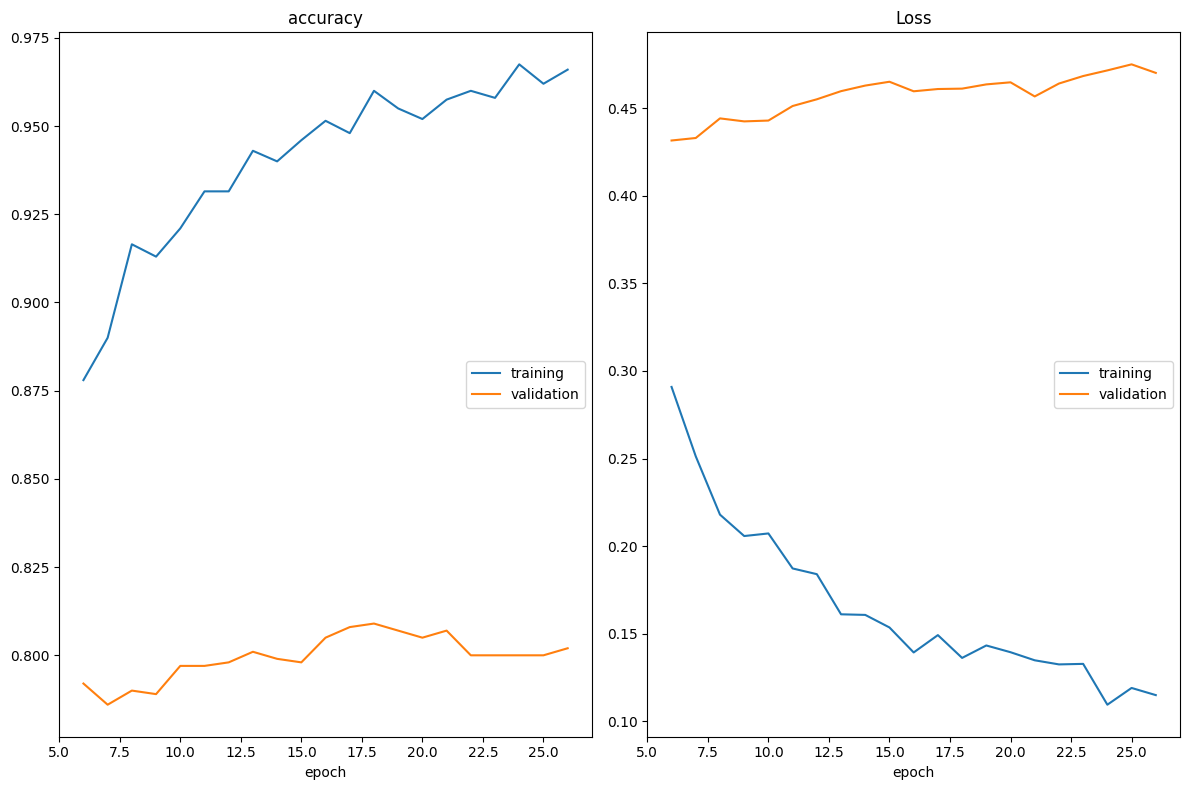

accuracy
	training         	 (min:    0.878, max:    0.967, cur:    0.966)
	validation       	 (min:    0.786, max:    0.809, cur:    0.802)
Loss
	training         	 (min:    0.109, max:    0.291, cur:    0.115)
	validation       	 (min:    0.432, max:    0.475, cur:    0.470)
32/32 [==============================] - 2s 53ms/step - loss: 0.4316 - accuracy: 0.7920
[test loss, test accuracy]: [0.4315849840641022, 0.7919999957084656]


In [12]:
for i in models:
    conv_base = i
    model_names.append(conv_base.name)
    train_model()

#df['Original Label'] =validation_label

In [10]:
def train_model2():
    model = Sequential()

    model.add(conv_base)
    model.add(Flatten())

    model.add(Dense(1000,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(1,'sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3,decay=0.2), loss = 'binary_crossentropy', metrics = ['accuracy'])

    from livelossplot.inputs.keras import PlotLossesCallback

    plot_loss_1 = PlotLossesCallback()

    # ModelCheckpoint callback - save best weights
    tl_checkpoint_1 = ModelCheckpoint(filepath=f'SLS Other Logs/WithoutDataAug{conv_base.name}/{conv_base.name}_weights.best.hdf5',
                                      save_best_only=True,
                                      verbose=1)

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True,
                               mode='min')

    hist = model.fit(train_ds,
                        epochs=30,
                        batch_size = batch_size,
                        validation_data=validation_ds,
                        callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],)
    
    model.save(f'SLS Other Logs/WithoutDataAug{conv_base.name}/{conv_base.name}.h5') # Save the entire model along with the optimizer state, etc.
    eval_result = model.evaluate(validation_ds)
    metrics.append(eval_result)

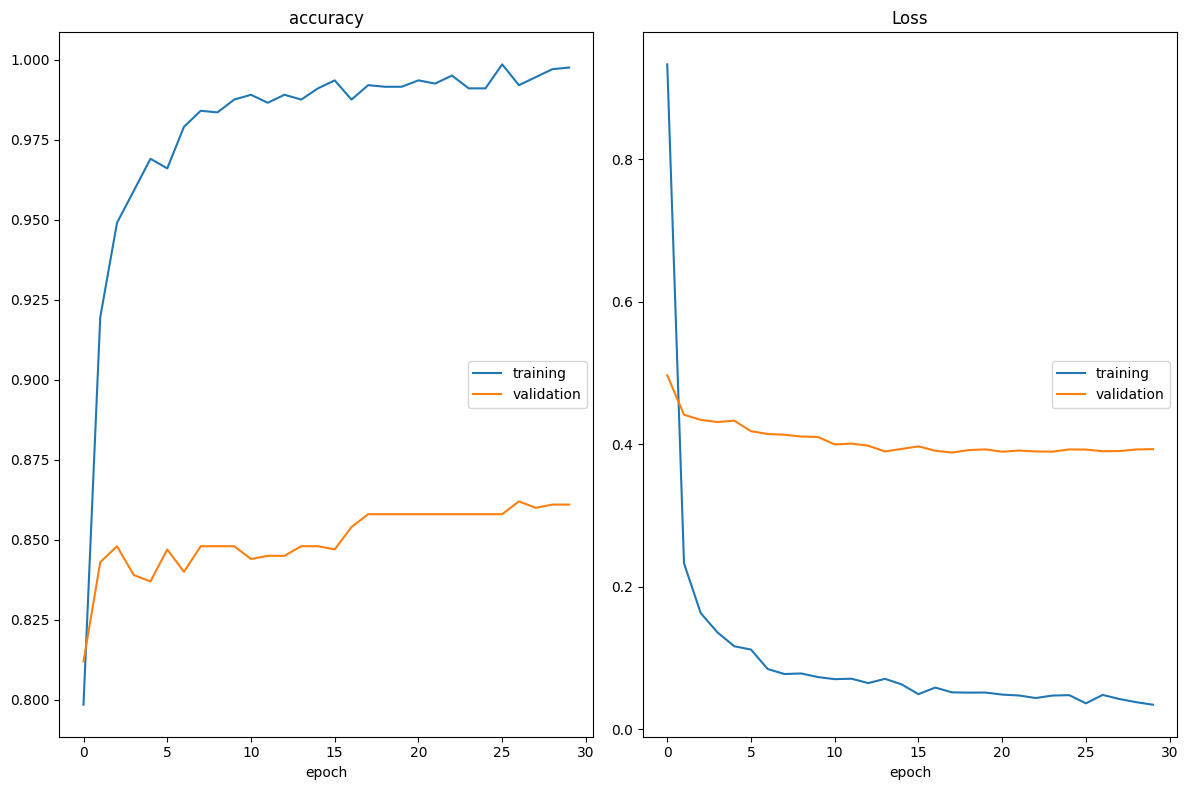

accuracy
	training         	 (min:    0.799, max:    0.998, cur:    0.998)
	validation       	 (min:    0.812, max:    0.862, cur:    0.861)
Loss
	training         	 (min:    0.034, max:    0.933, cur:    0.034)
	validation       	 (min:    0.388, max:    0.497, cur:    0.393)
32/32 [==============================] - 2s 52ms/step - loss: 0.3930 - accuracy: 0.8610


In [11]:
metrics = []
model_names =[]
for i in models:
    conv_base = i
    model_names.append(conv_base.name)
    train_model2()

In [11]:
import time
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(directory='SLS bed images/data_balanced/validation', 
                                                               labels = 'inferred', 
                                                               label_mode = 'int', 
                                                               batch_size=32,
                                                                shuffle=False,
                                                               image_size=(180, 180),
                                                                   seed=10)

Found 1000 files belonging to 2 classes.


In [12]:
df = pd.DataFrame()
test_df=pd.DataFrame()

In [13]:
model_names=['vgg19','inception_v3','resnet50']

validation_label = np.concatenate([y for x, y in validation_ds], axis=0)
for i in model_names:
    time.sleep(2.5)
    model = tf.keras.models.load_model(f'SLS Other Logs/WithoutDataAug{i}/{i}.h5')
    time.sleep(2.5)
    y_pred=model.predict(validation_ds)
    y_pred = y_pred.flatten()
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>0.5] = 1
    df[f'{i}']=y_pred
    time.sleep(2.5)

    y_pred=model.predict(test_ds)
    y_pred = y_pred.flatten()
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>0.5] = 1
    test_df[f'{i}']=y_pred
    time.sleep(2.5)

df['Original Label'] =validation_label

32/32 [==============================] - 2s 51ms/step


In [26]:
test_df.iloc[:,[0,2]]

,vgg19,resnet50
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
993,1.0,1.0
994,1.0,1.0
995,1.0,1.0
996,1.0,1.0


In [15]:
df2 = df.sample(frac=1).reset_index(drop=True)
df2

,vgg19,inception_v3,resnet50,Original Label
0,1.0,1.0,1.0,1
1,1.0,0.0,1.0,1
2,1.0,1.0,1.0,1
3,1.0,1.0,1.0,1
4,0.0,1.0,1.0,0
...,...,...,...,...
995,1.0,1.0,1.0,1
996,1.0,1.0,1.0,1
997,1.0,0.0,1.0,1
998,1.0,1.0,1.0,1


In [24]:
x, y = df2.iloc[:,[0,2]], df2.iloc[:,-1]

In [25]:
x

,vgg19,resnet50
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,1.0
...,...,...
995,1.0,1.0
996,1.0,1.0
997,1.0,1.0
998,1.0,1.0


In [18]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.10, random_state=42)

In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV ## GridSearchCV is used for hyperparameter tuning
neigh = xgb.XGBClassifier(max_depth=5,tree_method='gpu_hist')
parameters = {'learning_rate': [0.1, 0.2, 0.3],
                  'n_estimators': [5, 10, 20,50,100]}
clf = GridSearchCV(neigh, parameters,cv=3, scoring='roc_auc',return_train_score='true')
clf.fit(x,y)
print(clf.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [28]:
from sklearn.model_selection import GridSearchCV ## GridSearchCV is used for hyperparameter tuning
from sklearn.tree import DecisionTreeClassifier
dtree =  DecisionTreeClassifier()
param_grid = {
    'max_depth':[2,4,8,10,None],
    'min_samples_split':[0.25,0.5,1.0],'splitter':['best','random']
}

dtree = GridSearchCV(dtree,param_grid)
dtree.fit(x,y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 8, 10, None],
                         'min_samples_split': [0.25, 0.5, 1.0],
                         'splitter': ['best', 'random']})

In [30]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3),('xgb',clf),('dtree',dtree)],
        voting='soft')
eclf2 = eclf2.fit(x, y)
meta_pred=eclf2.predict(test_df.iloc[:,[0,2]])

In [31]:
from sklearn.metrics import accuracy_score

accuracy_score(test_label, meta_pred)

0.935871743486974

In [32]:
print(classification_report(meta_pred, test_label))
print(confusion_matrix(meta_pred, test_label))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       452
           1       0.98      0.90      0.94       546

    accuracy                           0.94       998
   macro avg       0.94      0.94      0.94       998
weighted avg       0.94      0.94      0.94       998

[[444   8]
 [ 56 490]]


In [25]:
 metrics

[[0.16919374465942383, 0.9589999914169312],
 [0.653336226940155, 0.6639999747276306],
 [0.3930080533027649, 0.8610000014305115]]